# [PTM] Section 2


## 4. 실제 데이터를 텐서로 표현해보기
### 4.1 이미지 다루기
- 파이토치에서 기대하는 방식에 맞춰, 이미지의 다양한 부분을 담은 텐서 표현으로 데이터를 변환해야 함
- 일반적으로 8비트를 사용하지만, 의학이나 광학에서는 12비트/16비트를 사용하는 경우도 있음

#### 4.1.1 컬러 채널 더하기
#### 4.1.2 이미지 파일 로딩

In [4]:
import imageio.v2 as imageio # 단일화된 API로 다양한 데이터 타입을 다룰 수 있음

In [5]:
img_arr = imageio.imread("./data/p1ch4/image-dog/bobby.jpg")
img_arr.shape

(720, 1280, 3)

이미지를 다루는 토치 텐서는, C * H * W (채널, 높이, 너비) 순으로 배치되어야 함

#### 4.1.3 레이아웃 변경하기

In [7]:
import torch

In [8]:
# 채널 2 - 채널 0 - 채널 1
img = torch.from_numpy(img_arr)
out = img.permute(2, 0, 1)

In [9]:
out.shape

torch.Size([3, 720, 1280])

텐서플로에서는, H * W * C 레이아웃을 기본으로 하고 있음  
-> 레이아웃 형태는 저수준에서 장단점이 있음

In [10]:
batch_size = 3
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8)

batch.shape

torch.Size([3, 3, 256, 256])

In [11]:
# 이미지를 읽어 텐서에 저장
import os

data_dir = "./data/p1ch4/image-cats/"
filenames = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1]==".png"]

for i, filename in enumerate(filenames):
    img_arr = imageio.imread(os.path.join(data_dir, filename))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2, 0, 1)
    img_t = img_t[:3]
    batch[i] = img_t

#### 4.1.4 데이터 정규화
- 신경망은 입력값이, 0~1 / -1~1 인 경우 훈련 성능이 가장 좋은 특징을 보임
- 대부분의 경우 텐서를 부동 소수점으로 캐스팅하고 픽셀값을 정규화

In [12]:
batch = batch.float()
batch /= 255.0

In [13]:
n_channels = batch.shape[1]
for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c]-mean) / std

### 4.2 3차원 이미지: 용적 데이터
- 2차원 단면을 스택처럼 쌓아 3차원 텐서를 만들면, 대상의 3차원 해부도를 표현한 용적 데이터를 만들 수 있음  
- 채널 차원 뒤에, 깊이(depth) 차원을 갖게 됨 -> N * C * D * H * W (배치 * 채널 * 깊이 * 높이 * 너비)

#### 4.2.1 특수 포맷 로딩
- `volread` 인자로 받은 디렉토리에 있는 DICOM 파일을 연속적으로 조합해 3차원 넘파이 배열로 만듬

In [16]:
dir_path = "./data/p1ch4/volumetric-dicom/2-LUNG 3.0  B70f-04083"
vol_arr = imageio.volread(dir_path, "DICOM")
vol_arr.shape

Reading DICOM (examining files): 1/99 files (1.0%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 99/99  (100.0%)


(99, 512, 512)

In [17]:
# 채널 차원 생성
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol, 0)

vol.shape

torch.Size([1, 99, 512, 512])

### 4.3 테이블 데이터 표현하기
#### 4.3.1 실세계 데이터셋 사용하기
- 딥러닝의 첫 단계는, 상이한 형태의 값으로 이뤄진 실세계 데이터를 부동 소수점 수로 이뤄진 텐서로 만들어서 신경망으로 넣을 준비를 하는 것

#### 4.3.2 와인 데이터를 텐서로 읽어오기
- 판다스를 사용하는게 메모리를 가장 적게 사용할 수 있는 방법임

In [27]:
import csv
import numpy as np

In [26]:
wine_path = "./data/p1ch4/tabular-wine/winequality-white.csv"
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";", skiprows=1)

wineq_numpy

array([[ 7.  ,  0.27,  0.36, ...,  0.45,  8.8 ,  6.  ],
       [ 6.3 ,  0.3 ,  0.34, ...,  0.49,  9.5 ,  6.  ],
       [ 8.1 ,  0.28,  0.4 , ...,  0.44, 10.1 ,  6.  ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  0.46,  9.4 ,  6.  ],
       [ 5.5 ,  0.29,  0.3 , ...,  0.38, 12.8 ,  7.  ],
       [ 6.  ,  0.21,  0.38, ...,  0.32, 11.8 ,  6.  ]], dtype=float32)

In [28]:
col_list = next(csv.reader(open(wine_path), delimiter=";"))

wineq_numpy.shape, col_list

((4898, 12),
 ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol',
  'quality'])

In [29]:
# np -> torch
wineq = torch.from_numpy(wineq_numpy)

wineq.shape, wineq.dtype

(torch.Size([4898, 12]), torch.float32)

##### Note! 연속값, 순서값, 카테고리값
- 연속값(continuous)
  - 숫자로 표현했을 때 가장 직관적인 값
  - 값 사이의 순서가 정해져 있으며, 차이가 의미를 지님
- 순서값(ordinal)
  - 연속값과 같이 연속적으로 나열되어 있지만, 관계가 고정되어 있지 않음
- 카테고리값(categorical)
  - 순서나 숫자적인 의미가 없는 값
  - 명목 척도(nominal scale)

#### 4.3.3 점수 표현하기

In [30]:
data = wineq[:, :-1]
data, data.shape

(tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
         [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
         [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
         ...,
         [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
         [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
         [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]]),
 torch.Size([4898, 11]))

In [31]:
target = wineq[:, -1]
target, target.shape

(tensor([6., 6., 6.,  ..., 6., 7., 6.]), torch.Size([4898]))

In [32]:
target = wineq[:, -1].long()
target

tensor([6, 6, 6,  ..., 6, 7, 6])

#### 4.3.4 원핫 인코딩(one-hot encoding)

In [33]:
target_onehot = torch.zeros(target.shape[0], 10)
target_onehot.scatter_(1, target.unsqueeze(1), 1.0)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [35]:
target

tensor([6, 6, 6,  ..., 6, 7, 6])

In [34]:
target.unsqueeze(1)

tensor([[6],
        [6],
        [6],
        ...,
        [6],
        [7],
        [6]])

#### 4.3.5 언제 카테고리화 할 것인가


In [36]:
data_mean = torch.mean(data, dim=0)
data_mean

tensor([6.8548e+00, 2.7824e-01, 3.3419e-01, 6.3914e+00, 4.5772e-02, 3.5308e+01,
        1.3836e+02, 9.9403e-01, 3.1883e+00, 4.8985e-01, 1.0514e+01])

In [37]:
data_var = torch.var(data, dim=0)
data_var

tensor([7.1211e-01, 1.0160e-02, 1.4646e-02, 2.5726e+01, 4.7733e-04, 2.8924e+02,
        1.8061e+03, 8.9455e-06, 2.2801e-02, 1.3025e-02, 1.5144e+00])

`dim=0`은 차원 0에 대해 축소 연산이 수행됨을 지정

In [38]:
data_normalized = (data-data_mean)/torch.sqrt(data_var)
data_normalized

tensor([[ 1.7208e-01, -8.1761e-02,  2.1326e-01,  ..., -1.2468e+00,
         -3.4915e-01, -1.3930e+00],
        [-6.5743e-01,  2.1587e-01,  4.7996e-02,  ...,  7.3995e-01,
          1.3422e-03, -8.2419e-01],
        [ 1.4756e+00,  1.7450e-02,  5.4378e-01,  ...,  4.7505e-01,
         -4.3677e-01, -3.3663e-01],
        ...,
        [-4.2043e-01, -3.7940e-01, -1.1915e+00,  ..., -1.3130e+00,
         -2.6153e-01, -9.0545e-01],
        [-1.6054e+00,  1.1666e-01, -2.8253e-01,  ...,  1.0049e+00,
         -9.6251e-01,  1.8574e+00],
        [-1.0129e+00, -6.7703e-01,  3.7852e-01,  ...,  4.7505e-01,
         -1.4882e+00,  1.0448e+00]])

#### 4.3.6 임계값으로 찾기

In [39]:
bad_indexes = target <= 3
bad_indexes.shape, bad_indexes.dtype, bad_indexes.sum()

(torch.Size([4898]), torch.bool, tensor(20))

In [40]:
bad_data = data[bad_indexes]
bad_data.shape

torch.Size([20, 11])

In [41]:
bad_data = data[target<=3]
mid_data = data[(target>3) & (target<7)]
good_data = data[target>=7]

In [44]:
bad_mean = torch.mean(bad_data, dim=0)
mid_mean = torch.mean(mid_data, dim=0)
good_mean = torch.mean(good_data, dim=0)

for i, args in enumerate(zip(col_list, bad_mean, mid_mean, good_mean)):
    print("{:2} {:20} {:6.2f} {:6.2f} {:6.2f}".format(i, *args))

 0 fixed acidity          7.60   6.89   6.73
 1 volatile acidity       0.33   0.28   0.27
 2 citric acid            0.34   0.34   0.33
 3 residual sugar         6.39   6.71   5.26
 4 chlorides              0.05   0.05   0.04
 5 free sulfur dioxide   53.33  35.42  34.55
 6 total sulfur dioxide 170.60 141.83 125.25
 7 density                0.99   0.99   0.99
 8 pH                     3.19   3.18   3.22
 9 sulphates              0.47   0.49   0.50
10 alcohol               10.34  10.26  11.42


In [45]:
total_sulfur_thr = 141.83
total_sulfur_data = data[:, 6]
pred_idx = torch.lt(total_sulfur_data, total_sulfur_thr)

pred_idx.shape, pred_idx.dtype, pred_idx.sum()

(torch.Size([4898]), torch.bool, tensor(2727))

In [46]:
actual_idx = target > 5

actual_idx.shape, actual_idx.dtype, actual_idx.sum()

(torch.Size([4898]), torch.bool, tensor(3258))

임계값으로 예측한 수량과 실제 수량의 차이가 크므로, 완벽하지 않다는 증거를 확보한 셈

In [47]:
n_matches = torch.sum(actual_idx & pred_idx).item()
n_pred = torch.sum(pred_idx).item()
n_actual = torch.sum(actual_idx).item()

n_matches, n_matches/n_pred, n_matches/n_actual

(2018, 0.74000733406674, 0.6193984039287906)

### 4.4 시계열 데이터 다루기
#### 4.4.1 시간 차원 더하기

In [48]:
bikes_numpy = np.loadtxt(
    "./data/p1ch4/bike-sharing-dataset/hour-fixed.csv",
    dtype=np.float32, delimiter=",", skiprows=1, converters={1: lambda x: float(x[8:10])}
)

bikes = torch.from_numpy(bikes_numpy)
bikes

tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 3.0000e+00, 1.3000e+01,
         1.6000e+01],
        [2.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 8.0000e+00, 3.2000e+01,
         4.0000e+01],
        [3.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 5.0000e+00, 2.7000e+01,
         3.2000e+01],
        ...,
        [1.7377e+04, 3.1000e+01, 1.0000e+00,  ..., 7.0000e+00, 8.3000e+01,
         9.0000e+01],
        [1.7378e+04, 3.1000e+01, 1.0000e+00,  ..., 1.3000e+01, 4.8000e+01,
         6.1000e+01],
        [1.7379e+04, 3.1000e+01, 1.0000e+00,  ..., 1.2000e+01, 3.7000e+01,
         4.9000e+01]])

#### 4.4.2 시간 단위로 데이터 만들기
- 일별로 매 시간의 데이터셋을 구하기 위해 동일 텐서를 24시간 배치로 바라보는 뷰가 필요

In [49]:
bikes.shape, bikes.stride()

(torch.Size([17520, 17]), (17, 1))

17,520 시간에 17개 열 -> 일자, 시간, 17개 열의 세 개 축으로 만들기

In [50]:
daily_bikes = bikes.view(-1, 24, bikes.shape[1])
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 24, 17]), (408, 17, 1))

In [51]:
# C 개의 채널을 가진 하루를 L시간으로 나눈 N개의 연속된 값을 갖는다고 볼 때
daily_bikes = daily_bikes.transpose(1, 2)
daily_bikes.shape, daily_bikes.stride()

(torch.Size([730, 17, 24]), (408, 1, 17))

#### 4.4.3 훈련 준비

In [52]:
first_day = bikes[:24].long()
weather_onehot = torch.zeros(first_day.shape[0], 4)
first_day[:, 9]

tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2])

In [53]:
# 날씨 수준에 따라 행렬을 원핫 인코딩으로 변환
weather_onehot.scatter(dim=1, index=first_day[:, 9].unsqueeze(1).long()-1, value=0.1)

tensor([[0.1000, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1000, 0.0000, 0.0000],
        [0.1000, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1000, 0.0000, 0.0000],
        [0.0000, 0.1000, 0.0000, 0.0000],
        [0.0000, 0.1000, 0.0000, 0.0000],
        [0.0000, 0.1000, 0.0000, 0.0000],
        [0.0000, 0.1000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1000, 0.0000],
        [0.0000, 0.0000, 0.1000, 0.0000],
        [0.0000, 0.1000, 0.0000, 0.0000],
        [0.0000, 0.1000, 0.0000, 0.0000],
        [0.0000, 0.1000, 0.0000, 0.0000],
        [0.0000, 0.1000, 0.0000, 0

In [54]:
torch.cat((bikes[:24], weather_onehot), 1)[:1]

tensor([[ 1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  6.0000,
          0.0000,  1.0000,  0.2400,  0.2879,  0.8100,  0.0000,  3.0000, 13.0000,
         16.0000,  0.0000,  0.0000,  0.0000,  0.0000]])

In [55]:
daily_weather_onehot = torch.zeros(daily_bikes.shape[0], 4, daily_bikes.shape[2])

daily_weather_onehot.shape

torch.Size([730, 4, 24])

In [56]:
daily_bikes = torch.cat((daily_bikes, daily_weather_onehot), dim=1)

In [57]:
daily_bikes[:, 9, :] = (daily_bikes[:, 9, :]-1.0)/3.0

In [58]:
temp = daily_bikes[:, 10, :]
temp_min = torch.min(temp)
temp_max = torch.max(temp)
daily_bikes[:, 10, :] = ((daily_bikes[:, 10, :] - torch.mean(temp)) / torch.std(temp))

### 4.5 텍스트 표현하기
- 딥러닝은, NLP 분야도 폭풍처럼 강타  
- 모델의 이전 출력과 현재의 입력을 섞는 식으로 반복해서 소비하는 형태의 모델이 대표적 (RNN)
- 트랜스포머(Transformer)로 불리는 종류의 신경망으로 과거의 정보를 포함하는 유연한 방법을 통해 큰 성공을 거두고 있음

#### 4.5.1 텍스트를 숫자로 변환하기
신경망으로 텍스트를 다루는 직관적인 방법은 두 가지  
1. 문자 단위로 한 번에 하나의 문자를 처리하는 것
2. 단어 단위로 신경망이 바라보는 세밀한 엔티티로 개별 단어를 처리하는 것

In [59]:
with open("./data/p1ch4/jane-austen/1342-0.txt", encoding="utf8") as f:
    text = f.read()

#### 4.5.2 문자 원핫 인코딩
- 분석 대상 텍스트에 있는 문자 집합으로 한정하여 원핫 인코딩  

In [61]:
lines = text.split("\n")
line = lines[200]
line

'“Impossible, Mr. Bennet, impossible, when I am not acquainted with him'

In [62]:
# 행 전체의 문자를 원핫 인코딩한 문자의 총 수를 담을 텐서
letter_t = torch.zeros(len(line), 128)
letter_t.shape

torch.Size([70, 128])

In [63]:
for i, letter in enumerate(line.lower().strip()):
    letter_index = ord(letter) if ord(letter) < 128 else 0
    letter_t[i][letter_index] = 1

#### 4.5.3 모든 단어를 원핫 인코딩하기

In [68]:
# 텍스트를 받아, 소문자로 바꾸고 구두점을 날리는 함수
def clean_words(input_str):
    punctuation = '.,;:"!?”“_-'
    word_list = input_str.lower().replace("\n", " ").split()
    word_list = [word.strip(punctuation) for word in word_list]
    return word_list

words_in_line = clean_words(line)
line, words_in_line

('“Impossible, Mr. Bennet, impossible, when I am not acquainted with him',
 ['impossible',
  'mr',
  'bennet',
  'impossible',
  'when',
  'i',
  'am',
  'not',
  'acquainted',
  'with',
  'him'])

In [69]:
word_list = sorted(set(clean_words(text)))
word2index_dict = {word:i for (i, word) in enumerate(word_list)}

len(word2index_dict), word2index_dict["impossible"]

(7261, 3394)

In [70]:
word_t = torch.zeros(len(words_in_line), len(word2index_dict))
for i, word in enumerate(words_in_line):
    word_index = word2index_dict[word]
    word_t[i][word_index] = 1
    print("{:2} {:4} {}".format(i, word_index, word))
    
print(word_t.shape)

 0 3394 impossible
 1 4305 mr
 2  813 bennet
 3 3394 impossible
 4 7078 when
 5 3315 i
 6  415 am
 7 4436 not
 8  239 acquainted
 9 7148 with
10 3215 him
torch.Size([11, 7261])


#### 4.5.4 텍스트 임베딩
#### 4.5.5 청사진으로서의 텍스트 임베딩

## 5. 학습 기법

### 5.1 시대를 초월하는 모델링 학습
### 5.2 학습은 파라미터 추정에 불과하다
- 입력 및 입력에 대응하는 출력인 실측 자료(ground truth)와 가중치 초깃값이 주어졌을 때, 모델에 입력 데이터가 들어가고(순방향) 실측괎과 출력 결과값을 비교해서 오차를 계산
- 모델의 파라미터(가중치)를 최적화하기 위해 가중치를 오차값에 따라 일정 단위만큼(기울기, gradient) 변경
- 이 변경값은 합성 함수(역방향 전달)의 미분값을 연속으로 계산하는 규칙(chain rule)을 통해 정해짐

#### 5.2.1 온도 문제
온도계를 읽고 일치하는 온도를 기록한 데이터셋을 만든 후, 학습을 위해 모델을 하나 골라 오차가 충분히 낮아질 때까지 반복적으로 가중치를 조절해, 우리가 이해하는 단위로 새로운 눈금을 해석할 수 있도록 만들기

#### 5.2.2 데이터 수집

In [71]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] # 섭씨
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] # 우리가 모르는 단위
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

#### 5.2.3 데이터 시각화

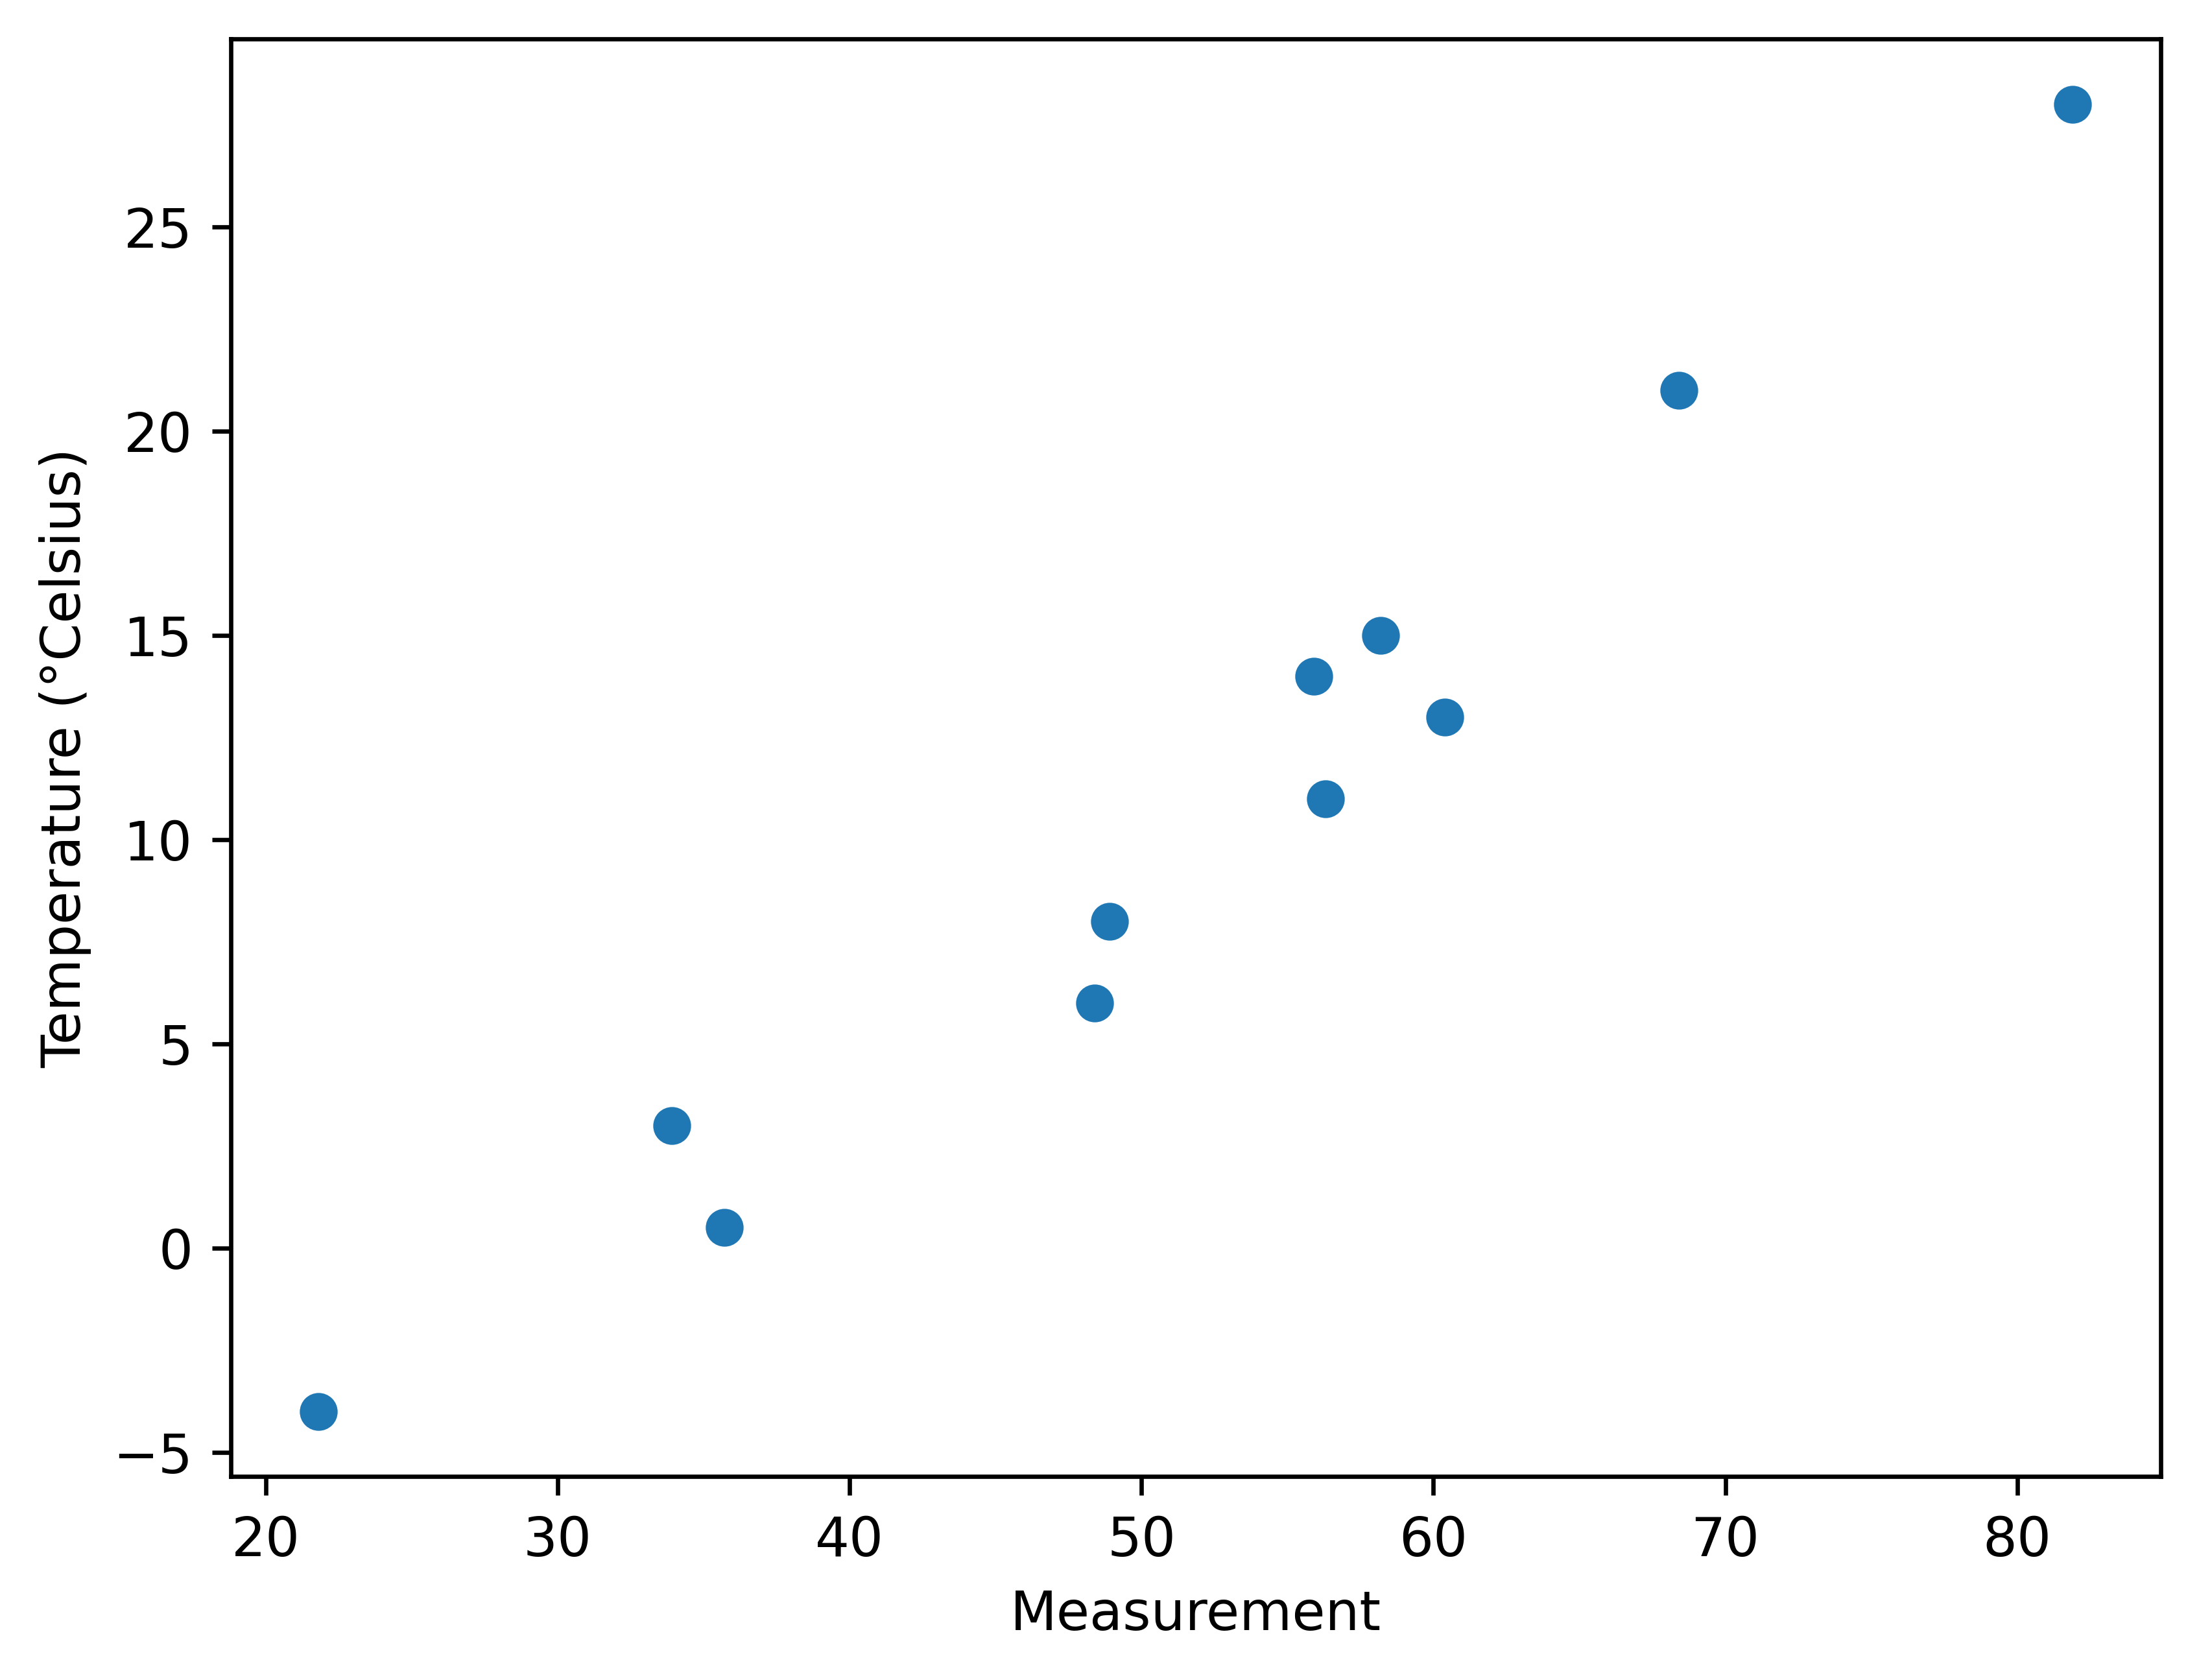

In [123]:
fig = plt.figure(dpi=600)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.show()

#### 5.2.4 선형 모델
- `t_c = w * t_u + b`라고 가정, 모델의 파라미터로 w와 b를 데이터 기반으로 추정해야 함  
- 오차 측정을 어떻게 할지 구체적으로 정의해야하는데, **손실 함수(loss function)**라고 불리는 측정 함수를 만들되, 오차가 높으면 함수의 출력값도 높아지도록 정의  
- 손실 함수의 값이 최소인 지점에서 w와 b를 찾는 과정을 최적화 과정

### 5.3 손실을 줄이기 위한 방안
- 손실 함수(비용 함수)는 학습 과정이 최소화하고자 하는 단일 값을 계산하는 함수
- 일반적으로 훈련 샘플로부터 기대하는 출력값과 모델이 샘플에 대해 실제 출력한 값 사이의 차이를 계산

#### 5.3.1 파이토치로 문제 풀어보기


In [80]:
def model(t_u, w, b):
    return w*t_u+b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p-t_c)**2
    return squared_diffs.mean()

In [81]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [82]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

### 5.4 경사를 따라 내려가기
- 경사 하강(gradient descent) 알고리즘을 사용해 파라미터 관점에서 손실 함수를 최적화

#### 5.4.1 손실 줄이기

In [83]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w+delta, b), t_c) - loss_fn(model(t_u, w-delta, b), t_c)) / (2.0 * delta)

현재의 w와 b 값에서 특정 단위만큼 w가 증가했을 때의 손실이 변하게 만드는데,  
값이 줄어들면 w를 더 늘려서 손실을 최소화하고,  
값이 늘어아면 반대로 w를 줄여서 손실을 최소화하는 식

In [84]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [85]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b+delta), t_c) - loss_fn(model(t_u, w, b-delta), t_c)) / (2.0 * delta)
    
b = b - learning_rate * loss_rate_of_change_b

경사 하강법은 위와 같은 식의 평가를 반복함으로써 주어진 데이터에 대해 손실 계산값이 최소로 떨어지는 최적의 파라미터 값으로 수렴하게 되는 것

#### 5.4.2 분석

In [100]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # 도함수
    return dsq_diffs

In [102]:
# 모델에 미분 적용
def model(t_u, w, b):
    return w * t_u + b

def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

In [103]:
# 경사 함수 정의
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

#### 5.4.3 모델 적합을 위한 반복

In [104]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # forward
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # backward

        params = params - learning_rate * grad

        print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [105]:
training_loop(100, 1e-2, torch.tensor([1.0, 0.0]), t_u, t_c)

Epoch 1, Loss 1763.884766
Epoch 2, Loss 5802484.500000
Epoch 3, Loss 19408029696.000000
Epoch 4, Loss 64915905708032.000000
Epoch 5, Loss 217130525461053440.000000
Epoch 6, Loss 726257583152928129024.000000
Epoch 7, Loss 2429183416467662896627712.000000
Epoch 8, Loss 8125122549611731432050262016.000000
Epoch 9, Loss 27176882120842590626938030653440.000000
Epoch 10, Loss 90901105189019073810297959556841472.000000
Epoch 11, Loss inf
Epoch 12, Loss inf
Epoch 13, Loss inf
Epoch 14, Loss inf
Epoch 15, Loss inf
Epoch 16, Loss inf
Epoch 17, Loss inf
Epoch 18, Loss inf
Epoch 19, Loss inf
Epoch 20, Loss inf
Epoch 21, Loss inf
Epoch 22, Loss inf
Epoch 23, Loss nan
Epoch 24, Loss nan
Epoch 25, Loss nan
Epoch 26, Loss nan
Epoch 27, Loss nan
Epoch 28, Loss nan
Epoch 29, Loss nan
Epoch 30, Loss nan
Epoch 31, Loss nan
Epoch 32, Loss nan
Epoch 33, Loss nan
Epoch 34, Loss nan
Epoch 35, Loss nan
Epoch 36, Loss nan
Epoch 37, Loss nan
Epoch 38, Loss nan
Epoch 39, Loss nan
Epoch 40, Loss nan
Epoch 41, Loss

tensor([nan, nan])

In [106]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [107]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
    Params: tensor([2568.4011,   45.1637])
    Grad:   tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
    Params: tensor([-148527.7344,   -2616.3931])
    Grad:   tensor([15109614.0000,   266155.6875])
...
Epoch 10, Loss 90901105189019073810297959556841472.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

손실값이 무한대가 되어버림  
-> `params` 조정이 너무 크기 때문, 경사 값이 앞뒤로 진동하면서 조정 값이 점점 커지고 과잉 교정으로 이어짐  
=> 발산



조금씩 점차적으로 `params`를 조정하는 것이 목표  

In [108]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

#### 5.4.4 입력 정규화
가중치와 편향값의 범위가 다르다  
-> 하나를 조정하기에 적절한 크기의 학습률은 동시에 다른 값의 업데이트를 불안정하게 만들 수 있음  
-> 반대로, 한 파라미터를 업데이트하기에 적합한 학습률은 다른 파라미터 입장에서 충분히 크지 않을 수 있음  

=> 정규화를 통해 해결

In [109]:
# 정규화된 버전
t_un = 0.1 * t_u

In [110]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

In [113]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
    print_params=False)

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


#### 5.4.5 시각화

In [112]:
import matplotlib.pyplot as plt

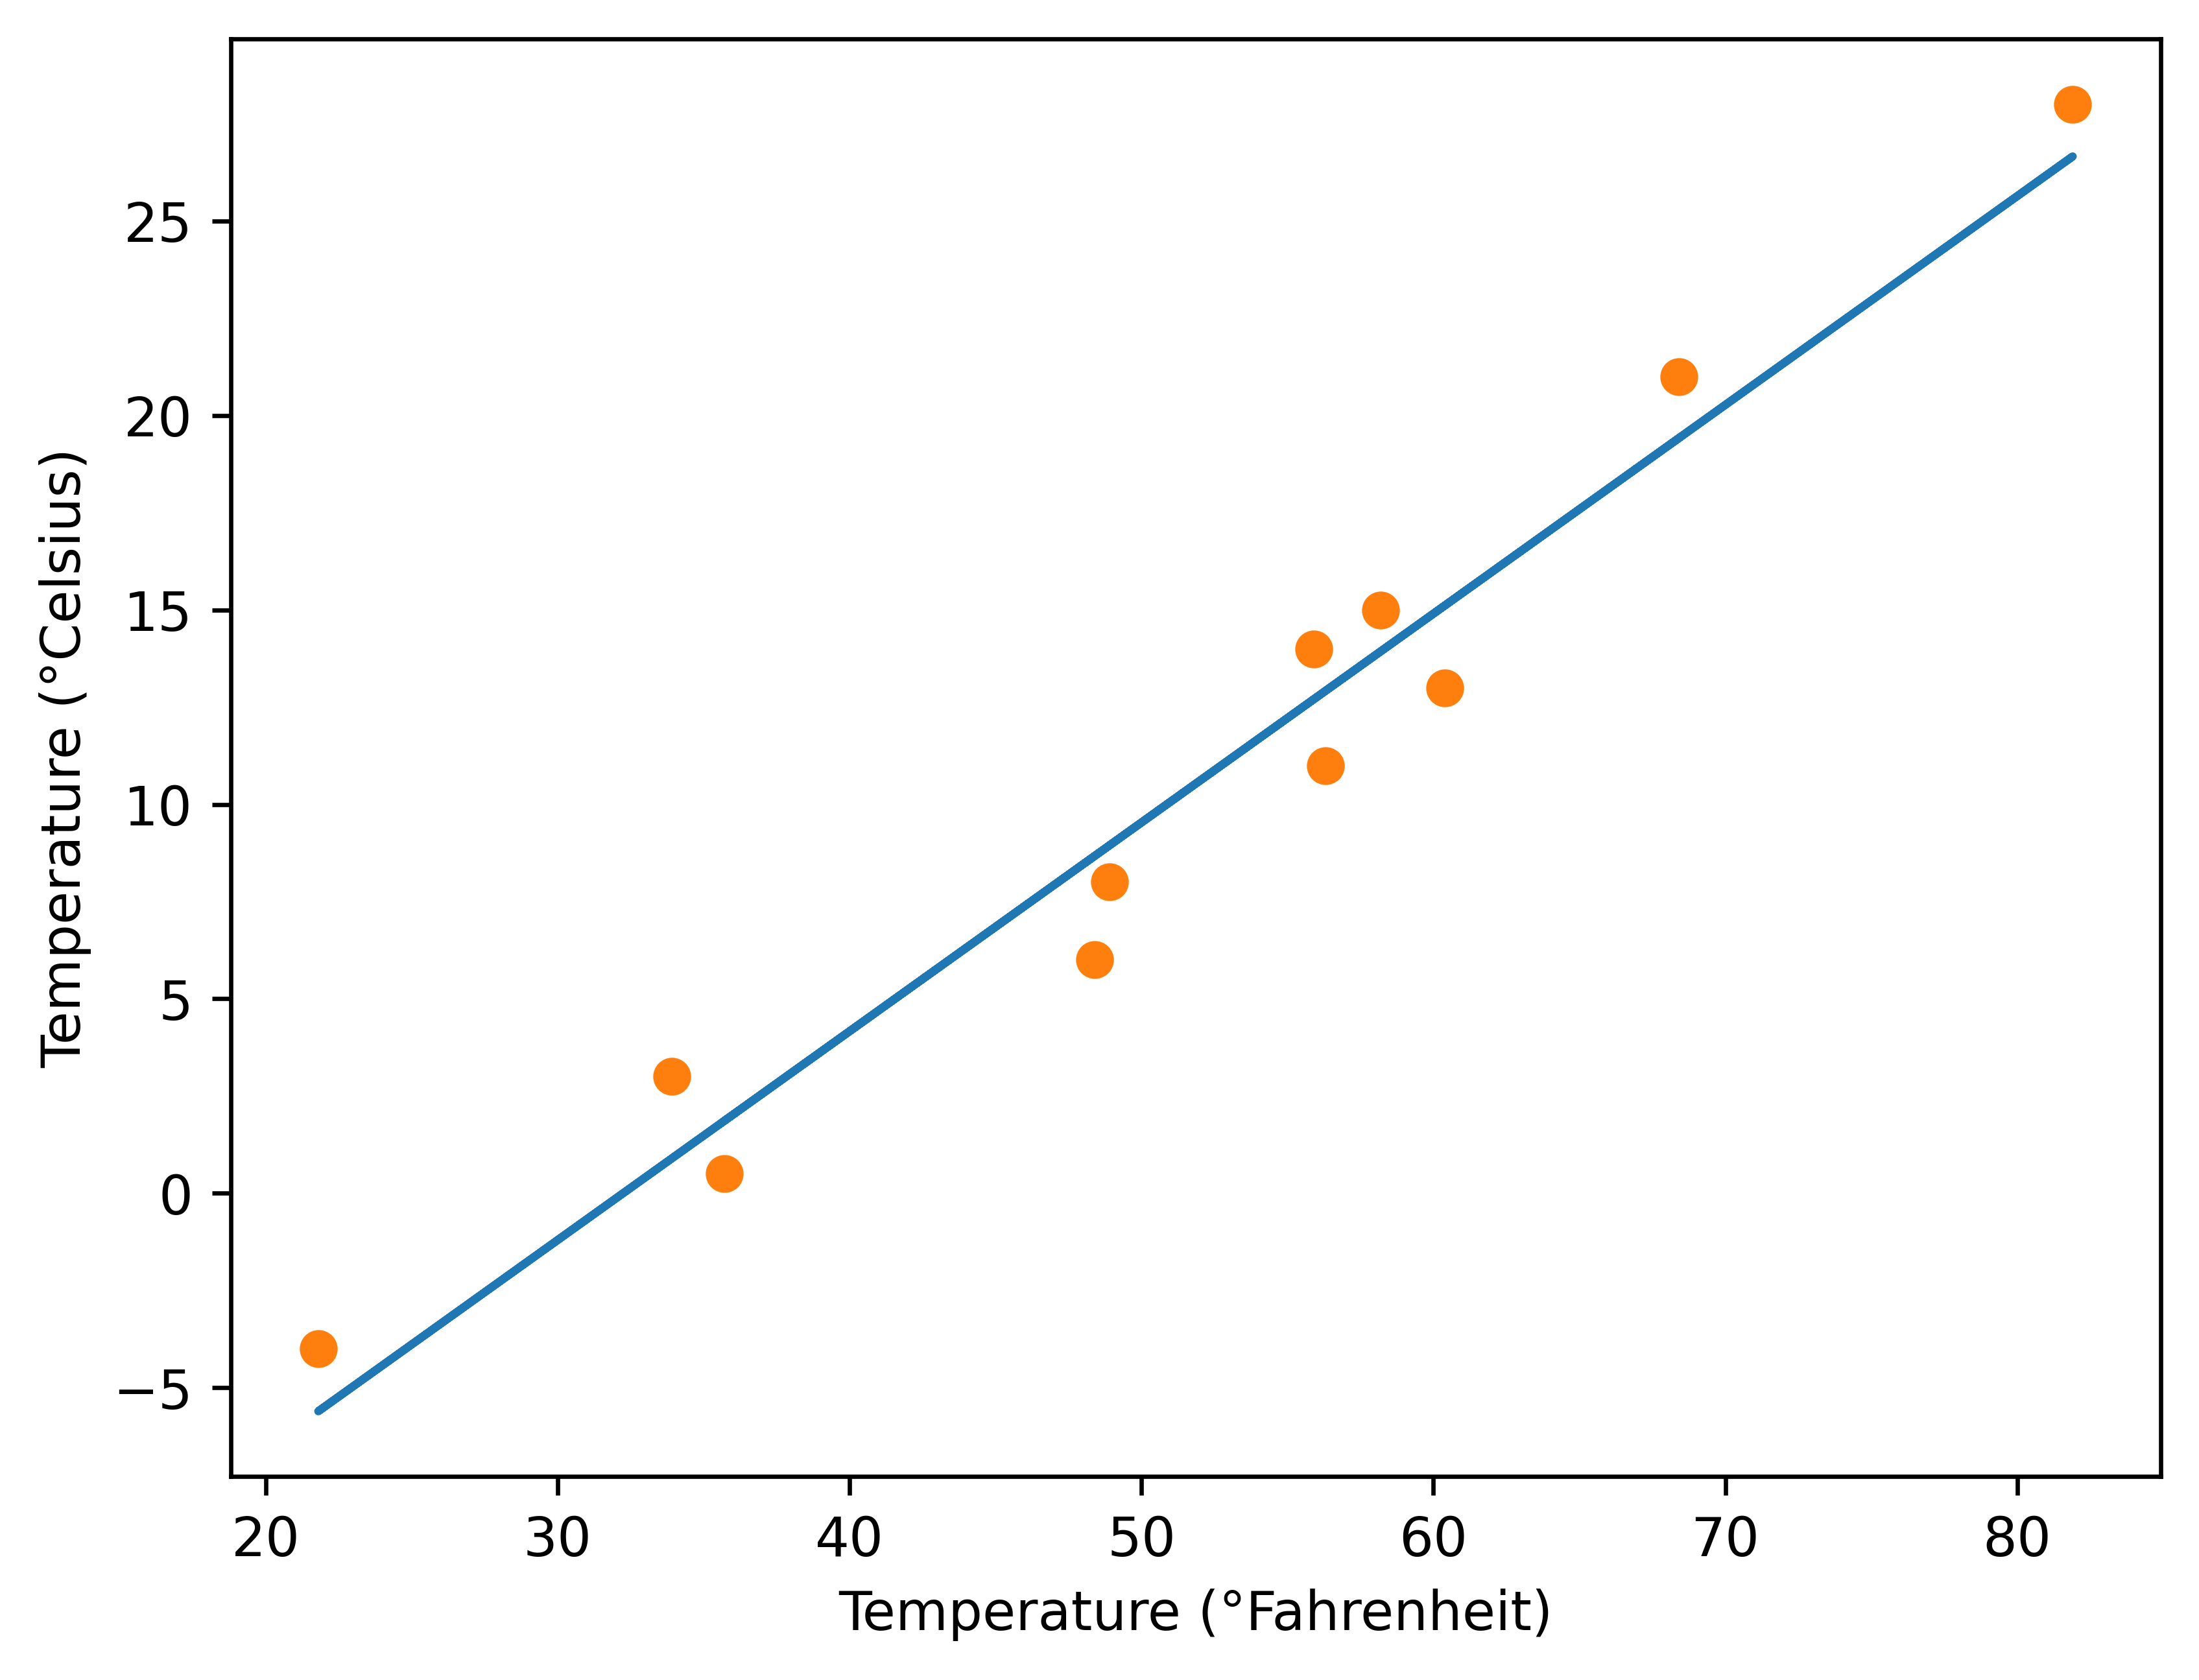

In [114]:
t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # 원본
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

### 5.5 파이토치의 자동미분: 모든 것을 역전파하라
#### 5.5.1 기울기 자동 계산
- 파이토치의 자동미분(autograd) 기능

In [115]:
# 자동 미분 적용
def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [116]:
# 초기화
params = torch.tensor([1.0, 0.0], requires_grad=True) # 연산 과정을 기록

##### 미분 속성 사용
`requires_grad`는 모든 연산 과정을 기록하라는 의미  

일반적으로 모든 텐서는 `grad` 속성을 갖는데, 주로 `None` 값임

In [119]:
params.grad is None

True

해당 값을 얻기 위해서는, 모델을 호출해 손실값을 구한 다음, loss 텐서에 대해 `backward`를 호출

In [120]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

`params`의 `grad`는 `parmas`의 각 요소에 대한 손실값의 미분을 포함하고 있음  


파이토치는 연쇄적으로 연결된 함수들(계산 그래프, computation graph)을 거쳐 손실에 대한 미분을 계산하고, 값을 텐서(그래프의 말단 노드)의 `grad` 속성에 **누적(accumulate)**  
-> 기울기를 명시적으로 0으로 초기화 할 필요가 있음

In [121]:
if params.grad is not None:
    params.grad.zero_()

In [126]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None: # backward 실행전에 수행
            params.grad.zero_()
        
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [127]:
training_loop(5000, 1e-2, torch.tensor([1.0, 0.0], requires_grad=True), t_un, t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

#### 5.5.2 골라쓰는 옵티마이저


In [129]:
import torch.optim as optim

In [130]:
# 경사 하강 옵티마이저 사용하기
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [131]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

따로 건드리지 않아도, `step`을 통해 알아서 조정 됨

In [132]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

In [133]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [134]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [135]:
# 다른 옵티마이저 사용
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
    n_epochs = 2000, 
    optimizer = optimizer,
    params = params,
    t_u = t_u,
    t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

#### 5.5.3 훈련, 검증, 과적합
손실 함수에 패널티항(penalization term)을 두어 모델의 적합(fitting)이 더 천천히 그리고 부드럽게 만들어지도록하는 방법

In [136]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 2,  6,  3,  9, 10,  8,  7,  5,  4]), tensor([1, 0]))

In [137]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [138]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        val_t_p = model(val_t_u, *params) 
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}," \
                f" Validation loss {val_loss.item():.4f}")
            
    return params

In [139]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un, 
    val_t_u = val_t_un, 
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 89.3172, Validation loss 40.0765
Epoch 2, Training loss 37.0205, Validation loss 25.6802
Epoch 3, Training loss 30.1377, Validation loss 29.0447
Epoch 500, Training loss 7.6324, Validation loss 9.6569
Epoch 1000, Training loss 3.9177, Validation loss 4.3025
Epoch 1500, Training loss 3.2837, Validation loss 2.8423
Epoch 2000, Training loss 3.1755, Validation loss 2.3674
Epoch 2500, Training loss 3.1570, Validation loss 2.1931
Epoch 3000, Training loss 3.1539, Validation loss 2.1248


tensor([  5.2459, -16.6438], requires_grad=True)

#### 5.5.4 자동미분의 주의사항과 자동미분 끄기
- 두 개의 그래프가 공우하는 유일한 텐서는 파라미터 텐서뿐임

In [140]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad(): # 콘텍스트 관리자
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False # <2>
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

In [141]:
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train): # model과 loss_fn을 실행하되, is_train 인자에 따라 자동미분의 사용 여부를 설정할 수 있음
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss

`set_grad_enable`를 통한 콘텍스트 설정으로 `autograd`를 켤지 끌지를 제어 할 수 있음